In [0]:
# pip install

In [0]:
import pandas as pd
import numpy as np
import tqdm
import re

In [7]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir(f'/content/drive/My Drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Constant
TYPE_IP_BRAS = {
    "89.239.189.1": "БРАС-1",
    "89.239.189.2": "БРАС-2"
}

LOGIN_STATUS_ERROR = {
    "OK": False,
}

RECORD_IS_BAD = {
    "huawei_save_sessid": True,
    "billing-accounting": False,
    "billing-authentication": False,
}

TYPE_RECORD = [
    "accounting",
    "authentication"
]

RADIUS_TYPE = {
    "": "основной",
    "": "резервный"
}

In [0]:
# re compile
re_date = re.compile("(\w{3}\s*\d{1,2}\s*\d\d:\d\d:\d\d)")
re_login = re.compile("(/0 '[0-9, a-z, A-Z]{8}[-]?[0-9, a-z, A-Z]?[0-9, a-z, A-Z]?@[0-9, a-z, A-Z]?[0-9, a-z, A-Z]?[0-9, a-z, A-Z]?[0-9, a-z, A-Z]?[0-9, a-z, A-Z]?[0-9, a-z, A-Z]?)")
re_status = re.compile(" - (\w*\s?\w*\s?\w*\??\w*\s?\w*)\.? -- ")
re_session = re.compile(",(RADIUS,\d),")
re_delay = re.compile("delay (\d.\d+)")
re_alive = re.compile(",PPP,(\w*),") # 
re_flow = re.compile("\d*.\d*.\d*.\d*,\d*,\d*,(\d*),(\d*), \d*.\d*.\d*.\d*") # 
re_rad = re.compile(" (\w+) radius") # 
re_record = re.compile("\[\d+\] (\w+[_, -]\w+):")
re_mac = re.compile("(\w{2}:\w{2}:\w{2}:\w{2}:\w{2}:\w{2})")
re_bras = re.compile("(89.239.189.\d:\d{9})")
re_session_id = re.compile("(ULSK-BR\w*),")
re_ips = re.compile("(\w{2}\,\d*.\d*.\d*.\d*),0[,,)]+")

In [0]:
class DataLog:

    def __init__(self, string: str):
        """
        {
          status: (200 ('success'), 'failed')
          type_record: ('accounting', authentication)
          errors:
          data: {
            error:
            data_info
          }
        }
        """
        self.status = "" # статус парсинга
        self.type_record = "" # тип записи
        self.errors = [] # ошибки парсинга

        self.data = {
            "all_information": string.strip(),
            "log_date": "",
            "login": "",
            "login_status": "",
            "ip_bras": "",
            "session_id": "",
            "session": "",
            "mac_abonent": "",
            "ip_abonent": "",
            "delay": "",
            "alive": "",
            "flow_in": "",
            "flow_out": "",
            "radius": "",
            "errors": [],
            "is_error": False
        }

    def transform_data(self):
        """
        """
        data = self.data["all_information"]

        # get date
        date = re_date.search(data)
        if date is None:
            self.data["log_date"] = None
            self.errors.append("Date записи не распознан")
        else:
            self.data["log_date"] = date.groups()[0]

        # get login
        login = re_login.search(data)
        if login is None:
            self.data["login"] = None
            self.errors.append("login записи не распознан")
        else:
            self.data["login"] = login.groups()[0][4:]

        # get ip bras
        ip_bras = re_bras.search(data)
        if ip_bras is None:
            self.data["ip_bras"] = None
            self.errors.append("ip bras записи не распознан")
        else:
            self.data["ip_bras"] = ip_bras.groups()[0]

        # get session id
        session_id = re_session_id.search(data)
        if session_id is None:
            self.data["session_id"] = None
            self.errors.append("session id записи не распознан")
        else:
            self.data["session_id"] = session_id.groups()[0]

        # get session
        session = re_session.search(data)
        if session is None:
            self.data["session"] = None
            self.errors.append("session записи не распознан")
        else:
            self.data["session"] = session.groups()[0]

        # get mac abonent
        mac_abonent = re_mac.search(data)
        if mac_abonent is None:
            self.data["mac_abonent"] = None
            self.errors.append("mac abonent записи не распознан")
        else:
            self.data["mac_abonent"] = mac_abonent.groups()[0]

        # get ip abonent
        ip_abonent = re_ips.search(data)
        if ip_abonent is None:
            self.data["ip_abonent"] = None
            self.errors.append("ip abonent записи не распознан")
        else:
            self.data["ip_abonent"] = ip_abonent.groups()[0][3:]

        # get delay
        delay = re_delay.search(data)
        if delay is None:
            self.data["delay"] = None
            self.errors.append("delay записи не распознан")
        else:
            self.data["delay"] = delay.groups()[0]

        # get alive
        alive = re_alive.search(data)
        if alive is None:
            self.data["alive"] = None
            self.errors.append("alive записи не распознан")
        else:
            self.data["alive"] = alive.groups()[0]

        # get flow
        flow = re_flow.search(data)
        if flow is None:
            self.data["flow_in"] = None
            self.data["flow_out"] = None
            self.errors.append("flow записи не распознан")
        else:
            self.data["flow_in"] = flow.groups()[0]
            self.data["flow_out"] = flow.groups()[1]

        # get type radius
        radius = re_rad.search(data)
        if radius is None:
            self.data["radius"] = None
            self.errors.append("rad записи не распознан")
        else:
            self.data["radius"] = radius.groups()[0]

        self.status = "success"

    def get_info(self):
        return {
            "status": self.status,
            "type_record":self.type_record,
            "errors": self.errors,
            "data": self.data
        }

    def run(self):
        data = self.data['all_information']

        # work with record
        record = re_record.search(data)
        if record is None:
            self.type_record = None
            self.status = "failed"
            self.errors.append("Type record записи не распознан")
            return self.get_info()
        self.type_record = record.groups()[0]

        if self.type_record == "huawei_save_sessid":
            self.status = "failed"
            self.errors.append(f"Запись {self.type_record} пропущена.")
            return self.get_info()

        # work with status
        # print(data)
        status = re_status.search(data)
        if status is None:
            self.status = "failed"        
            self.errors.append("Status записи не распознан")
            return self.get_info()
        self.data['login_status'] = status.groups()[0]

        if not self.data['login_status'] == "OK":
            self.data["errors"].append(f"Login_status = {self.data['login_status']}")
            self.data["is_error"] = True
        
        self.transform_data()

        return self.get_info()



In [0]:
a = "Apr 29 06:08:38 rad radiusd: [17892] Billing-Accounting: 75/0 '0A4997B0-03@dhcp' via radius@startip_nn - OK -- input (2020.04.29 06:08:38,89.239.189.1:153224783,Virtual-Access,Framed,PPP,Start,ULSK-BR09232161500000563c2e122501,RADIUS,4,b0:b2:dc:88:ff:7d,92.252.138.145,0) delay 0.000032"

In [0]:
dl = DataLog(a)

In [13]:
dl.run()

{'data': {'alive': 'Start',
  'all_information': "Apr 29 06:08:38 rad radiusd: [17892] Billing-Accounting: 75/0 '0A4997B0-03@dhcp' via radius@startip_nn - OK -- input (2020.04.29 06:08:38,89.239.189.1:153224783,Virtual-Access,Framed,PPP,Start,ULSK-BR09232161500000563c2e122501,RADIUS,4,b0:b2:dc:88:ff:7d,92.252.138.145,0) delay 0.000032",
  'delay': '0.000032',
  'errors': [],
  'flow_in': None,
  'flow_out': None,
  'ip_abonent': '92.252.138.145',
  'ip_bras': '89.239.189.1:153224783',
  'is_error': False,
  'log_date': 'Apr 29 06:08:38',
  'login': '0A4997B0-03@dhcp',
  'login_status': 'OK',
  'mac_abonent': 'b0:b2:dc:88:ff:7d',
  'radius': 'rad',
  'session': 'RADIUS,4',
  'session_id': 'ULSK-BR09232161500000563c2e122501'},
 'errors': ['flow записи не распознан'],
 'status': 'success',
 'type_record': 'Billing-Accounting'}

In [14]:
logs=[]
with open("/content/drive/My Drive/data_in/radius.log(1).1",encoding="cp1251") as log:
    text = log.readline()
    i = 0
    j = 0
    
    for k in tqdm.tqdm_notebook(range(1000000)):        
        try:
            text = log.readline()
            if text == '':
                break
                
            i += 1
            line = text
            logs.append(line)
            
        except:
            j += 1

print(j)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



0


In [15]:
log_data = DataLog(string=logs[2])
log_data.run()

{'data': {'alive': 'Alive',
  'all_information': "May  2 00:11:14 nfc radiusd: [17328] Billing-Accounting: 133/0 'OAXHLWA9@pppoe' via radius@startip_nn - OK -- input (2020.05.02 00:11:14,89.239.189.1:102888519,Virtual-Access,Framed,PPP,Alive,ULSK-BR06231109500000de0e57158174,RADIUS,,393292-HDSLAM56-DS atm 0/0/0/52:0.33,100.74.87.198,0,3127501,5977761900,50271361952, 89.239.189.1, 393292-HDSLAM56-DS atm 0/0/0/52:0.33, ULSK-BR06231109500000de0e57158174, d4:bf:7f:85:c8:01) delay 0.240214",
  'delay': '0.240214',
  'errors': [],
  'flow_in': '5977761900',
  'flow_out': '50271361952',
  'ip_abonent': '100.74.87.198',
  'ip_bras': '89.239.189.1:102888519',
  'is_error': False,
  'log_date': 'May  2 00:11:14',
  'login': 'OAXHLWA9@pppoe',
  'login_status': 'OK',
  'mac_abonent': 'd4:bf:7f:85:c8:01',
  'radius': 'nfc',
  'session': None,
  'session_id': 'ULSK-BR06231109500000de0e57158174'},
 'errors': ['session записи не распознан'],
 'status': 'success',
 'type_record': 'Billing-Accounting'}

In [16]:
data_objects = []
# i = 0
for i in tqdm.tqdm_notebook(range(len(logs[:1500000]))):
    # print(i)
    # print(log[i])
    log_data = DataLog(string=logs[i])
    data_objects.append(log_data.run())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
dd=data_objects.copy()

In [0]:
for i in range(len(data_objects)):
    if data_objects[i]!={}:
        data_objects[i].setdefault("status", 'No')
        data_objects[i].setdefault("type_record", 'No')
        data_objects[i].setdefault("errors", 'No') # array
        data_objects[i]["data"].setdefault('all_information', 'No')
        data_objects[i]['data'].setdefault('log_date', 'No')
        data_objects[i]["data"].setdefault('login', 'No')
        data_objects[i]["data"].setdefault('login_status', 'No')
        data_objects[i]["data"].setdefault('ip_bras', 'No')
        data_objects[i]["data"].setdefault('session_id', 'No')
        data_objects[i]["data"].setdefault('session', 'No')
        data_objects[i]["data"].setdefault('mac_abonent', 'No')
        data_objects[i]["data"].setdefault('ip_abonent', 'No')
        data_objects[i]["data"].setdefault('session', 'No')
        data_objects[i]["data"].setdefault('delay', 'No')
        data_objects[i]["data"].setdefault('alive', 'No')
        data_objects[i]["data"].setdefault('flow_in', 'No')
        data_objects[i]["data"].setdefault('flow_out', 'No')
        data_objects[i]["data"].setdefault('radius', 'No')
        data_objects[i]["data"].setdefault('errors', 'No') # array

In [0]:
status = []
type_record = []
errors = [] # array
data_all_information=[]
log_datе=[]
data_login=[]
data_login_status=[]
data_ip_bras=[]
data_session_id=[]
data_session=[]
data_mac_abonent=[]
data_ip_abonent=[]
data_delay=[]
data_alive = []
data_flow_in = []
data_flow_out = []
data_radius = []
data_errors = [] # array

for i in range(len(data_objects)):
    status.append(data_objects[i]["status"])
    type_record.append(data_objects[i]["type_record"])
    errors.append("||".join(data_objects[i]["errors"])) # array
    data_all_information.append(data_objects[i]["data"]['all_information'])
    log_datе.append(data_objects[i]["data"]['log_date'])
    data_login.append(data_objects[i]["data"]['login'])
    data_login_status.append(data_objects[i]["data"]['login_status'])
    data_ip_bras.append(data_objects[i]["data"]['ip_bras'])
    data_session_id.append(data_objects[i]["data"]['session_id'])
    data_session.append(data_objects[i]["data"]['session'])
    data_mac_abonent.append(data_objects[i]["data"]['mac_abonent'])
    data_ip_abonent.append(data_objects[i]["data"]['ip_abonent'])
    data_delay.append(data_objects[i]["data"]['delay'])
    data_alive.append(data_objects[i]["data"]['alive'])
    data_flow_in.append(data_objects[i]["data"]['flow_in'])
    data_flow_out.append(data_objects[i]["data"]['flow_out'])
    data_radius.append(data_objects[i]["data"]['radius'])
    data_errors.append("||".join(data_objects[i]["data"]['errors'])) # array

In [20]:
data=pd.DataFrame()


data['status']=status
data['type_record']=type_record
data['errors']=errors
data['data_all_information']=data_all_information
data['data_datе']=log_datе
data['data_login']=data_login
data['data_login_status']=data_login_status
data['data_ip_bras']=data_ip_bras
data['data_session_id']=data_session_id
data['data_session']=data_session
data['data_mac_abonent']=data_mac_abonent
data['data_ip_abonent']=data_ip_abonent
data['data_delay']=data_delay
data['data_alive']=data_alive
data['data_flow_in']=data_flow_in
data['data_flow_out']=data_flow_out
data['data_radius']=data_radius
data['data_errors']=data_errors

data

,status,type_record,errors,data_all_information,data_datе,data_login,data_login_status,data_ip_bras,data_session_id,data_session,data_mac_abonent,data_ip_abonent,data_delay,data_alive,data_flow_in,data_flow_out,data_radius,data_errors
0,failed,huawei_save_sessid,Запись huawei_save_sessid пропущена.,May 2 00:11:14 nfc radiusd: [03975] huawei_sa...,,,,,,,,,,,,,,
1,success,Billing-Accounting,,May 2 00:11:14 rad radiusd: [17558] Billing-A...,May 2 00:11:14,GBRFnJAM@pppoe,OK,89.239.189.2:253891725,ULSK-BR152331165000008e1c0b021168,"RADIUS,1",ec:08:6b:b7:72:1a,95.68.136.235,0.273068,Alive,2989776,73828767,rad,
2,success,Billing-Accounting,session записи не распознан,May 2 00:11:14 nfc radiusd: [17328] Billing-A...,May 2 00:11:14,OAXHLWA9@pppoe,OK,89.239.189.1:102888519,ULSK-BR06231109500000de0e57158174,None,d4:bf:7f:85:c8:01,100.74.87.198,0.240214,Alive,5977761900,50271361952,nfc,
3,success,Billing-Accounting,,May 2 00:11:14 rad radiusd: [17595] Billing-A...,May 2 00:11:14,GBRFnJAM@pppoe,OK,89.239.189.2:253891725,ULSK-BR152331165000008e1c0b021168,"RADIUS,6",ec:08:6b:b7:72:1a,95.68.136.235,0.280033,Alive,9250671,303541285,rad,
4,failed,huawei_save_sessid,Запись huawei_save_sessid пропущена.,May 2 00:11:14 rad radiusd: [03402] huawei_sa...,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,success,Billing-Accounting,session записи не распознан,May 2 03:38:07 rad radiusd: [17624] Billing-A...,May 2 03:38:07,0A49F5C4-18@dhcp,OK,89.239.189.1:253892091,ULSK-BR152331531000009c93a6092433,None,00:1f:ce:7c:b0:db,92.252.147.240,0.297059,Alive,662298106,5240919721,rad,
999996,success,Billing-Accounting,session записи не распознан,May 2 03:38:07 rad radiusd: [17665] Billing-A...,May 2 03:38:07,OAXXsLXA@pppoe,OK,89.239.189.1:102888469,ULSK-BR06231104500000632e2a025393,None,34:8a:ae:50:16:32,100.74.67.14,0.301668,Alive,550849464,11031821480,rad,
999997,success,Billing-Accounting,,May 2 03:38:07 rad radiusd: [11399] Billing-A...,May 2 03:38:07,0A49EC76-0D@dhcp,OK,89.239.189.1:153223513,ULSK-BR09232034500000f8ff4d150339,"RADIUS,4",84:a4:23:39:8d:2e,92.252.131.76,0.316724,Alive,444294807,10134285010,rad,
999998,success,Billing-Accounting,,May 2 03:38:07 rad radiusd: [17697] Billing-A...,May 2 03:38:07,0A49EC76-0D@dhcp,OK,89.239.189.1:153223513,ULSK-BR09232034500000f8ff4d150339,"RADIUS,5",84:a4:23:39:8d:2e,92.252.131.76,0.324091,Alive,7467414373,752479731481,rad,


In [0]:
import datetime
from datetime import datetime

In [22]:
pip install timestring

In [23]:
import timestring

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [0]:
df=data.copy()
df=df.query("type_record in ['Billing-Accounting', 'Billing-Authentication']")

In [25]:
len(df)

847740

In [26]:
df['type_record'].value_counts()

Billing-Accounting        792870
Billing-Authentication     54870
Name: type_record, dtype: int64

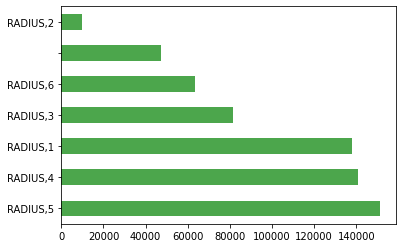

In [27]:
df['data_session'].value_counts().plot.barh(color="green", alpha=0.7);

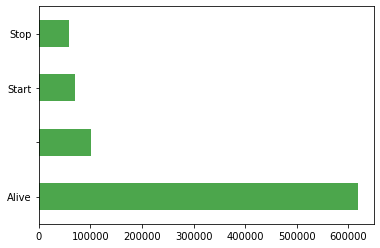

In [28]:
df['data_alive'].value_counts().plot.barh(color="green", alpha=0.7);

In [0]:
import datetime
from datetime import datetime

In [30]:
pip install timestring

In [0]:
import timestring

In [32]:
dates=[]
for j in tqdm.tqdm_notebook(df['data_datе']):
    if j!= None:
        spl=j.split(' ')
        ll=[]
        for i in spl:
            if i!='':
                ll.append(i)
    #print(len(ll))
        if len(ll)>0:
            new_date=timestring.Date(ll[0]+' '+ll[1]+' '+'2020'+' '+ll[2])
        #else:
            #date = None
    #else:
        #date = None
        dates.append(new_date)
print(len(dates))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



847740


In [0]:
df['new_date']=new_date
del df['data_datе']

In [34]:
df['status'].value_counts()

success    800560
failed      47180
Name: status, dtype: int64

In [0]:
re_fail = re.compile(" - (.*) [-,—]{1,2} ") # TODO: add to class transf

**присоединим типы ошибок со статусом failed к нашему датафрейму**

In [36]:
fails=[]
j=0
for i in tqdm.tqdm_notebook(df['data_all_information']):
    j+=1
    fail=re_fail.search(i).groups()[0]
    fails.append(fail)
print(j)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



847740


In [0]:
fail=[]
for i in range(len(fails)):
    if fails[i]=='OK' or fails[i][:4]=='OK -':
        fail.append('no fail')
    else:
        fail.append(fails[i])

In [0]:
df['fails_type']=fail

**вычленим производиьтеля устройств по mac_ip**

In [39]:
df['data_mac_abonent'][1].rsplit(":",maxsplit=3)

['ec:08:6b', 'b7', '72', '1a']

In [40]:
mac_company=[]
j=0
for i in tqdm.tqdm_notebook(df['data_mac_abonent']):
    if i!= None:
        j+=1
        mac=i.rsplit(":",maxsplit=3)
        mac_company.append(mac[0])
    else:
        mac_company.append('no')
print(j)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



796155


In [0]:
len(mac_company)
df['mac_company']=mac_company

**определяем тип логина**

In [42]:
df['data_login'][2].split("@")

['OAXHLWA9', 'pppoe']

In [43]:
login_type=[]
j=0
for i in tqdm.tqdm_notebook(df['data_login']):
    if i!= None:
        j+=1
        login=i.split("@")
        if login!=['']:
          login_type.append(login[1])
        else:
          login_type.append('no')
    else:
        login_type.append('no')
print(j)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



512295


In [0]:
#del df['login_type']
df['login_type']=login_type

In [106]:
df['login_type'].value_counts()

no       382625
dhcp     327209
pppoe    137906
Name: login_type, dtype: int64

**определение коммутатора**

In [0]:
#k=df['data_login'][3].split("@")[0]
#l=int(k,16)
#tt='Gs9AWvsA@pppoe'
#k=tt.split("@")[0]
#l=int(k,16)
#l
#эта хрень не будет работать - нужны id с коммутаторов

**Ищем ошибку стоповые записи с нулевым потреблением трафика и большим значением ошибки**

In [46]:
df['data_alive'].value_counts()

Alive    618270
         100501
Start     70113
Stop      57622
Name: data_alive, dtype: int64

In [0]:
mist8 = df[df.data_alive == 'Stop']

In [95]:
res8 = mist8[(mist8.data_flow_in == '0') & (len(mist8.data_session_id) > 1)]
print(res8.data_delay.astype(float).mean(), res8.data_delay.max())

0.23294919818181808 0.683439


In [0]:
res8[res8.data_delay.astype(float) > 0.4].to_csv('/content/drive/My Drive/mist8.csv')

In [0]:
def mist8(data):
  mist8 = df[df.data_alive == 'Stop']
  res8 = mist8[(mist8.data_flow_in == '0') & (len(mist8.data_session_id) > 1)]
  res8 = res8[res8.data_delay.astype(float) > 0.4]
  if res8.shape[0] > 0:
    res8.to_csv('/content/drive/My Drive/mist8.csv')

In [0]:
res8.to_csv('/content/drive/My Drive/mist8.csv')

In [82]:
res8.groupby(data_session_id).count(data_delay)

KeyError: ignored

In [68]:
df[df.data_flow_in == '0']

,status,type_record,errors,data_all_information,data_login,data_login_status,data_ip_bras,data_session_id,data_session,data_mac_abonent,data_ip_abonent,data_delay,data_alive,data_flow_in,data_flow_out,data_radius,data_errors,new_date,fails_type,mac_company,login_type
1523,success,Billing-Accounting,login записи не распознан||session записи не р...,May 2 00:11:27 nfc radiusd: [16233] Billing-A...,None,OK,89.239.189.2:153224341,ULSK-BR092321173000003e71e9122529,None,28:ff:3e:1f:01:80,95.68.170.59,0.198174,Stop,0,2079,nfc,,2020-05-02 03:38:07,no fail,28:ff:3e,no
2878,success,Billing-Accounting,login записи не распознан||session записи не р...,May 2 00:11:37 rad radiusd: [17528] Billing-A...,None,OK,89.239.189.1:102888427,ULSK-BR06231100300000bfec5d240791,None,28:10:7b:48:1c:aa,89.239.168.171,0.167943,Stop,0,1040,rad,,2020-05-02 03:38:07,no fail,28:10:7b,no
4086,success,Billing-Accounting,login записи не распознан||ip bras записи не р...,May 2 00:11:48 nfc radiusd: [17328] Billing-A...,None,OK,None,ULSK-BR022300010000002f3f4d129769,None,24:d3:f2:f2:35:0e,100.74.232.137,0.308397,Stop,0,0,nfc,,2020-05-02 03:38:07,no fail,24:d3:f2,no
4401,success,Billing-Accounting,login записи не распознан||session записи не р...,May 2 00:11:50 rad radiusd: [17528] Billing-A...,None,OK,89.239.189.1:253891603,ULSK-BR152331043000002bc97a203863,None,ec:4c:4d:c3:47:5a,92.252.147.81,0.161018,Stop,0,892,rad,,2020-05-02 03:38:07,no fail,ec:4c:4d,no
5030,success,Billing-Accounting,session записи не распознан,May 2 00:11:56 nfc radiusd: [17406] Billing-A...,MmIDx0aY@pppoe,OK,89.239.189.1:253891567,ULSK-BR15233100700000def872167161,None,00:19:5b:73:9f:47,92.252.177.66,0.300498,Stop,0,6825,nfc,,2020-05-02 03:38:07,no fail,00:19:5b,pppoe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995026,success,Billing-Accounting,session записи не распознан,May 2 03:36:57 nfc radiusd: [17329] Billing-A...,0A49A69C-06@dhcp,OK,89.239.189.2:153224736,ULSK-BR09232156800000b49703128332,None,38:d8:2f:0f:28:ca,95.68.205.86,0.273193,Stop,0,1498,nfc,,2020-05-02 03:38:07,no fail,38:d8:2f,dhcp
995949,success,Billing-Accounting,ip bras записи не распознан||session записи не...,May 2 03:37:13 rad radiusd: [17553] Billing-A...,GsLAWvX8@pppoe,OK,None,ULSK-BR02230108800000b4c430171818,None,e8:de:27:51:4b:14,95.68.216.222,0.146374,Stop,0,576,rad,,2020-05-02 03:38:07,no fail,e8:de:27,pppoe
997498,success,Billing-Accounting,session записи не распознан,May 2 03:37:33 rad radiusd: [17557] Billing-A...,5sHXW8Lg@pppoe,OK,89.239.189.2:153224253,ULSK-BR0923210850000086a612153662,None,84:c9:b2:cd:b4:07,95.68.212.70,0.376602,Alive,0,161516,rad,,2020-05-02 03:38:07,no fail,84:c9:b2,pppoe
999049,success,Billing-Accounting,login записи не распознан||session записи не р...,May 2 03:37:51 rad radiusd: [17553] Billing-A...,None,OK,89.239.189.1:253891718,ULSK-BR15233115800000e73414119430,None,2c:39:96:14:5f:77,89.239.162.72,0.260954,Stop,0,362,rad,,2020-05-02 03:38:07,no fail,2c:39:96,no


In [66]:
mist8.data_flow_in.min()

'0'

In [0]:
tt=df[df['data_alive']=='Start']

In [0]:
#df.info()
#del df['data_all_information']
df[['status',  'data_login', 'data_session_id', 'data_ip_abonent','data_delay', 'data_alive', 'new_date','mac_company', 'login_type']][:1000].to_csv('/content/drive/My Drive/df_hach11.csv', sep=';')

In [0]:
dat=df.copy()
del dat['data_all_information']


In [0]:
del dat['errors']
del dat['data_login_status']
del dat['data_session']
del dat['data_delay']
del dat['data_radius']
del dat['data_errors']
del dat['data_mac_abonent']
del dat['type_record']
del dat['data_ip_bras']
del dat['status']
#del dat['data_alive']
del dat['fails_type']
del dat['mac_company']
del dat['login_type']

In [51]:
type(dat['new_date'][1])

timestring.Date.Date

In [0]:
dat=dat.query("data_alive in ['Start', 'Stop']")

In [0]:
dat=dat[dat.data_login!='None']

In [0]:
#dat.groupby(['data_session_id','data_login']).sort('new_date').count()
dat['rn']=dat.sort_values(['new_date']).groupby(['data_session_id','data_login']).cumcount() + 1


In [55]:
a='ULSK-BR152331165000008e1c0b021168'
b='ULSK-BR152331165000008e1c0b021168'
a==b

True

In [56]:
df[(df['2014y3']>25000)&(df['2014y3']<35000)]

KeyError: ignored

In [0]:
df.info()